### T-SNE implementation

The algorithm is applied to the two image classification datasets: MNIST и Caltech-101.

The code for the data preprocessing is stored in `preprocess_datasets.ipynb`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Datasets loading.

In [2]:
mnist_df = pd.read_csv('mnist_subset.csv')
mnist_features = [column for column in mnist_df.columns if column.startswith('pixel')]

caltech_df = pd.read_csv('caltech_101.csv')
caltech_features = [column for column in caltech_df.columns if column.startswith('pixel')]
print(np.unique(caltech_df.label.values))

['Faces' 'Faces_easy' 'Motorbikes' 'airplanes' 'watch']


In [3]:
mnist_df.head()

,Unnamed: 0,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label
0,47002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,36162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
2,44863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
3,43651,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,50317,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


### Standard implementation

In [4]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(mnist_df[mnist_features])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.840s...
[t-SNE] Computed neighbors for 10000 samples in 127.706s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.129556
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.793777
[t-SNE] KL divergence after 300 iterations: 2.806836
t-SNE done! Time elapse

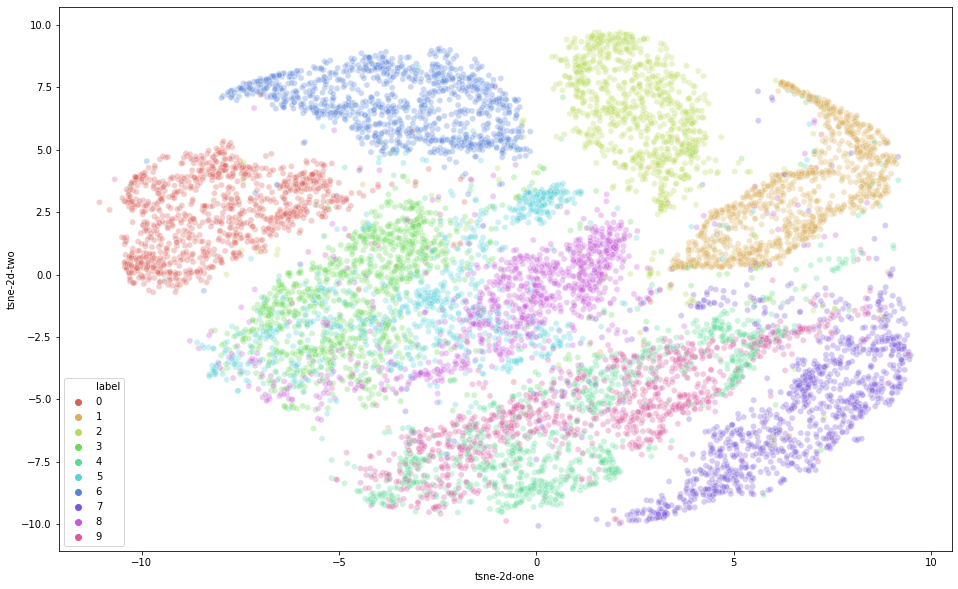

In [5]:
mnist_df['tsne-2d-one'] = tsne_results[:,0]
mnist_df['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=mnist_df,
    legend="full",
    alpha=0.3
)

In [6]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(caltech_df[caltech_features])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2707 samples in 1.362s...
[t-SNE] Computed neighbors for 2707 samples in 22.552s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2707
[t-SNE] Computed conditional probabilities for sample 2000 / 2707
[t-SNE] Computed conditional probabilities for sample 2707 / 2707
[t-SNE] Mean sigma: 489.703753
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.041039
[t-SNE] KL divergence after 300 iterations: 1.548104
t-SNE done! Time elapsed: 35.796010971069336 seconds


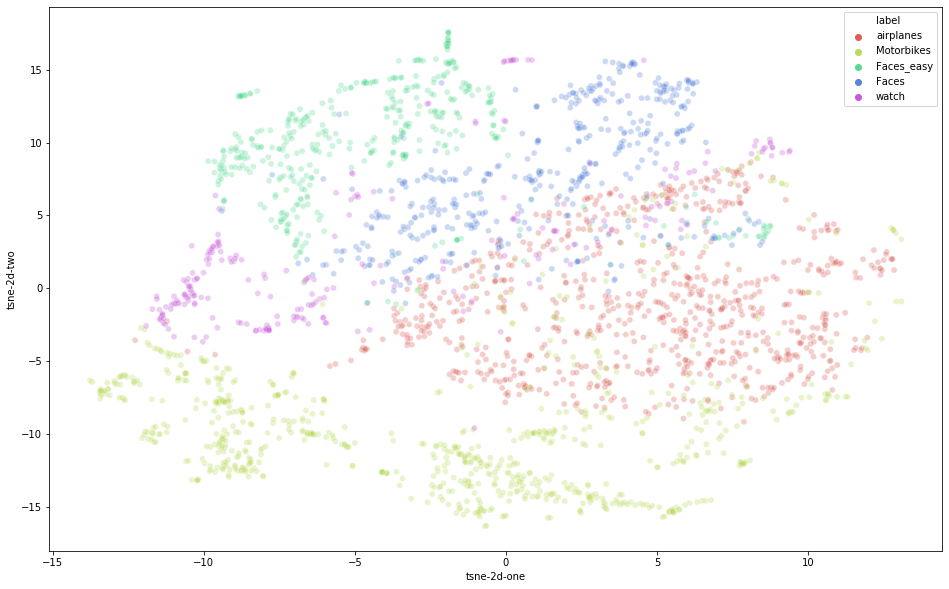

In [7]:
caltech_df['tsne-2d-one'] = tsne_results[:,0]
caltech_df['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 5),
    data=caltech_df,
    legend="full",
    alpha=0.3
)

#### Custom implementation

In [8]:
import numpy as np
import time
import warnings

from scipy import linalg
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.sparse import csr_matrix, issparse

from sklearn.neighbors import NearestNeighbors
from sklearn.base import BaseEstimator

from sklearn.decomposition import PCA
from sklearn.manifold import _utils  # type: ignore
from sklearn.manifold import _barnes_hut_tsne  # type: ignore
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.utils import check_random_state
from sklearn.utils._openmp_helpers import _openmp_effective_n_threads
from sklearn.utils.validation import check_non_negative
from sklearn.utils.validation import _deprecate_positional_args

In [9]:
MACHINE_EPSILON = np.finfo(np.double).eps

def get_kl_divergence_bh(params, P, degrees_of_freedom, n_samples, n_components,
                      angle=0.5, skip_num_points=0, verbose=False,
                      compute_error=True, num_threads=1):
    
    indptr = P.indptr.astype(np.int64, copy=False)
    neighbors = P.indices.astype(np.int64, copy=False)
    val_P = P.data.astype(np.float32, copy=False)
    
    X_embedded = params.reshape(n_samples, n_components)
    params = params.astype(np.float32, copy=False)
    

    grad = np.zeros(X_embedded.shape, dtype=np.float32)
    error = _barnes_hut_tsne.gradient(val_P, X_embedded, neighbors, indptr,
                                      grad, angle, n_components, verbose,
                                      dof=degrees_of_freedom,
                                      compute_error=compute_error,
                                      num_threads=num_threads)
    
    c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
    grad = grad.ravel() * c

    return error, grad

def get_joint_probabilities_nn(distances, desired_perplexity, verbose):
    distances.sort_indices()
    n_samples = distances.shape[0]
    distances_data = distances.data.reshape(n_samples, -1)
    distances_data = distances_data.astype(np.float32, copy=False)
    conditional_P = _utils._binary_search_perplexity(
        distances_data, desired_perplexity, verbose)
 
    # here we use sparse operations
    P = csr_matrix(
        (conditional_P.ravel(), distances.indices, distances.indptr),
        shape=(n_samples, n_samples)
    )
    
    P = P + P.T
    P /= np.maximum(P.sum(), MACHINE_EPSILON)

    return P

def get_gradient_descent_result(objective, p0, it, n_iter,
                      n_iter_check=1, n_iter_without_progress=300,
                      momentum=0.8, learning_rate=200.0, min_gain=0.01,
                      min_grad_norm=1e-7, verbose=0, args=None, kwargs=None):
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(float).max
    best_error = np.finfo(float).max
    best_iter = i = it

    time_begin = time.time()
    for i in range(it, n_iter):
        check_convergence = (i + 1) % n_iter_check == 0
        kwargs['compute_error'] = check_convergence or i == n_iter - 1

        error, grad = objective(p, *args, **kwargs)
        grad_norm = np.linalg.norm(grad)

        inc = update * grad < 0.0
        dec = np.invert(inc)
        gains[inc] += 0.2
        gains[dec] *= 0.8
        np.clip(gains, min_gain, np.inf, out=gains)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if check_convergence:
            time_end = time.time()
            duration = time_end - time_begin
            time_begin = time_end

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                break
            if grad_norm <= min_grad_norm:
                break

    return p, error, i


@_deprecate_positional_args
def trustworthiness(X, X_embedded, *, n_neighbors=5, metric='euclidean'):
    dist_X = pairwise_distances(X, metric=metric)
    if metric == 'precomputed':
        dist_X = dist_X.copy()

    np.fill_diagonal(dist_X, np.inf)
    ind_X = np.argsort(dist_X, axis=1)
    
    ind_X_embedded = NearestNeighbors(n_neighbors=n_neighbors).fit(
            X_embedded).kneighbors(return_distance=False)

    n_samples = X.shape[0]
    inverted_index = np.zeros((n_samples, n_samples), dtype=int)
    ordered_indices = np.arange(n_samples + 1)
    inverted_index[ordered_indices[:-1, np.newaxis],
                   ind_X] = ordered_indices[1:]
    ranks = inverted_index[ordered_indices[:-1, np.newaxis],
                           ind_X_embedded] - n_neighbors
    t = np.sum(ranks[ranks > 0])
    t = 1.0 - t * (2.0 / (n_samples * n_neighbors *
                          (2.0 * n_samples - 3.0 * n_neighbors - 1.0)))
    return t


class MyTSNE(BaseEstimator):
    _EXPLORATION_N_ITER = 250
    _N_ITER_CHECK = 50

    @_deprecate_positional_args
    def __init__(self, n_components=2, *, perplexity=30.0,
                 early_exaggeration=12.0, learning_rate=200.0, n_iter=1000,
                 n_iter_without_progress=300, min_grad_norm=1e-7,
                 metric="euclidean", init="random", verbose=0,
                 random_state=None, method='barnes_hut', angle=0.5,
                 n_jobs=None, square_distances='legacy'):
        
        self.n_components = n_components
        self.perplexity = perplexity
        self.early_exaggeration = early_exaggeration
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.n_iter_without_progress = n_iter_without_progress
        self.min_grad_norm = min_grad_norm
        self.metric = metric
        self.init = init
        self.verbose = verbose
        self.random_state = random_state
        self.method = method
        self.angle = angle
        self.n_jobs = n_jobs
        self.square_distances = square_distances

    def fit_implementation(self, X, skip_num_points=0):
        """Private function to fit the model using X as training data."""

        if self.angle < 0.0 or self.angle > 1.0:
            raise ValueError("'angle' must be between 0.0 - 1.0")

        if self.n_components > 3:
            raise ValueError("'n_components' should be less than 4")
            
        random_state = check_random_state(self.random_state)

        if self.early_exaggeration < 1.0:
            raise ValueError("early_exaggeration must be at least 1, but is {}"
                             .format(self.early_exaggeration))

        self.n_iter = max(self.n_iter, 250)

        n_samples = X.shape[0]

        neighbors_nn = None
        n_neighbors = min(n_samples - 1, int(3. * self.perplexity + 1))

        if self.verbose:
            print("[t-SNE] Computing {} nearest neighbors..."
                  .format(n_neighbors))

        knn = NearestNeighbors(algorithm='auto',
                                n_jobs=self.n_jobs,
                                n_neighbors=n_neighbors,
                                metric=self.metric)
        t0 = time.time()
        knn.fit(X)
        duration = time.time() - t0
        if self.verbose:
            print("[t-SNE] Indexed {} samples in {:.3f}s...".format(
                n_samples, duration))

        t0 = time.time()
        distances_nn = knn.kneighbors_graph(mode='distance')
        duration = time.time() - t0
        if self.verbose:
            print("[t-SNE] Computed neighbors for {} samples "
                  "in {:.3f}s...".format(n_samples, duration))

        # free the memory
        del knn

        if self.square_distances is True or self.metric == "euclidean":
            distances_nn.data **= 2

        P = get_joint_probabilities_nn(distances_nn, self.perplexity, self.verbose)

        X_embedded = 1e-4 * random_state.randn(
            n_samples, self.n_components).astype(np.float32)

        degrees_of_freedom = max(self.n_components - 1, 1)

        return self.run_tsne(P, degrees_of_freedom, n_samples,
                          X_embedded=X_embedded,
                          neighbors=neighbors_nn,
                          skip_num_points=skip_num_points)

    def run_tsne(self, P, degrees_of_freedom, n_samples, X_embedded,
              neighbors=None, skip_num_points=0):
        """ Runs t-SNE """
        
        params = X_embedded.ravel()

        opt_args = {
            "it": 0,
            "n_iter_check": self._N_ITER_CHECK,
            "min_grad_norm": self.min_grad_norm,
            "learning_rate": self.learning_rate,
            "verbose": self.verbose,
            "kwargs": dict(skip_num_points=skip_num_points),
            "args": [P, degrees_of_freedom, n_samples, self.n_components],
            "n_iter_without_progress": self._EXPLORATION_N_ITER,
            "n_iter": self._EXPLORATION_N_ITER,
            "momentum": 0.5,
        }
        
        obj_func = get_kl_divergence_bh
        opt_args['kwargs']['angle'] = self.angle
        
        opt_args['kwargs']['verbose'] = self.verbose
        opt_args['kwargs']['num_threads'] = _openmp_effective_n_threads()
        

        P *= self.early_exaggeration
        params, kl_divergence, it = get_gradient_descent_result(obj_func, params,
                                                      **opt_args)
        print("[t-SNE] KL divergence after %d iterations with early "
              "exaggeration: %f" % (it + 1, kl_divergence))

        P /= self.early_exaggeration
        remaining = self.n_iter - self._EXPLORATION_N_ITER
        if it < self._EXPLORATION_N_ITER or remaining > 0:
            opt_args['n_iter'] = self.n_iter
            opt_args['it'] = it + 1
            opt_args['momentum'] = 0.8
            opt_args['n_iter_without_progress'] = self.n_iter_without_progress
            params, kl_divergence, it = get_gradient_descent_result(obj_func, params,
                                                          **opt_args)

        # Save the final number of iterations
        self.n_iter_ = it

        print("[t-SNE] KL divergence after %d iterations: %f"
              % (it + 1, kl_divergence))

        X_embedded = params.reshape(n_samples, self.n_components)
        self.kl_divergence_ = kl_divergence

        return X_embedded

    def fit_transform(self, X, y=None):
        embedding = self.fit_implementation(X)
        self.embedding_ = embedding
        return self.embedding_

    def fit(self, X, y=None):
        self.fit_transform(X)
        return self

In [10]:
tsne = MyTSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(mnist_df[mnist_features])
print('My t-SNE done!')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.760s...
[t-SNE] Computed neighbors for 10000 samples in 210.194s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.129556
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.800705
[t-SNE] KL divergence after 300 iterations: 2.808561
My t-SNE done!


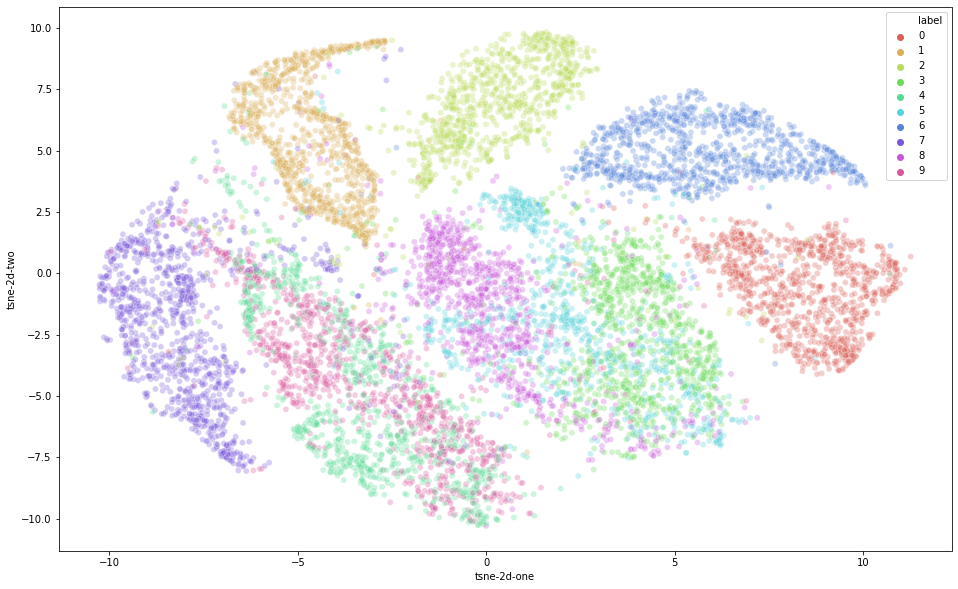

In [11]:
mnist_df['tsne-2d-one'] = tsne_results[:,0]
mnist_df['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=mnist_df,
    legend="full",
    alpha=0.3
)

In [12]:
tsne = MyTSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(caltech_df[mnist_features])
print('My t-SNE done!')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2707 samples in 2.084s...
[t-SNE] Computed neighbors for 2707 samples in 11.326s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2707
[t-SNE] Computed conditional probabilities for sample 2000 / 2707
[t-SNE] Computed conditional probabilities for sample 2707 / 2707
[t-SNE] Mean sigma: 388.433332
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.124603
[t-SNE] KL divergence after 300 iterations: 1.569556
My t-SNE done!


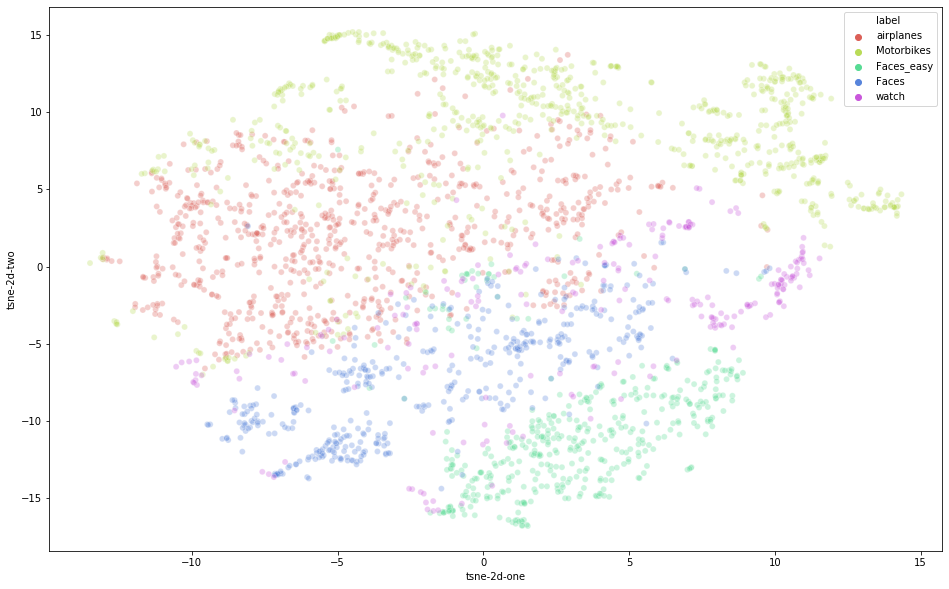

In [14]:
caltech_df['tsne-2d-one'] = tsne_results[:,0]
caltech_df['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 5),
    data=caltech_df,
    legend="full",
    alpha=0.3
)